<a href="https://colab.research.google.com/github/azure531/Demo/blob/main/Toxic_Comments_LSTM_GloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import re
from tqdm import tqdm_notebook

from nltk.corpus import stopwords

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [ ]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [ ]:
train = pd.read_csv('train.csv' )  # Change ';' if needed

test = pd.read_csv('test.csv')  # Change ';' if needed


In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
train.isnull().sum()

,0
id,0
comment_text,0
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0


In [ ]:
test.isnull().sum()

,0
id,0
comment_text,0


In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values
comments_train = train['comment_text']
comments_test = test['comment_text']

In [ ]:
comments_train = list(comments_train)

In [ ]:
def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output.strip())[1:-3].replace("  ", " ")

In [14]:
texts = []
import nltk
nltk.download('stopwords')
for line in tqdm_notebook(comments_train, total=159571):
    texts.append(clean_text(line))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-14-28809a2bf07e>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(comments_train, total=159571):


  0%|          | 0/159571 [00:00<?, ?it/s]

In [17]:
print('Sample data:', texts[1], y[1])

Sample data: aww matches background colour im seemingly stuck thanks talk 2151 january 11 2016  [0 0 0 0 0 0]


In [18]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

In [19]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 324669


In [20]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 6)


In [21]:
import numpy as np
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [22]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

In [23]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [12257  1283  6776   381  6352  1119]
validation:  [3037  312 1673   97 1525  286]


In [24]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [1268  136   50    5   18  363    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    

In [25]:
import numpy as np

embeddings_index = {}
with open('glove.txt', 'r', encoding='utf-8') as f:
    print('Loading GloVe from: glove.txt...', end='')
    for line in f:
        values = line.split()
        word = values[0]
        embeddings_index[word] = np.asarray(values[1:], dtype='float32')
print("Done.\n Proceeding with Embedding Matrix...", end="")
f.close()

# Determine the correct dimension size
#first_word_embedding = next(iter(embeddings_index.values()))
#EMBEDDING_DIM = len(first_word_embedding)

# Example word index
#word_index = {'example': 1, 'word': 2}

'''embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and len(embedding_vector) == EMBEDDING_DIM:
        embedding_matrix[i] = embedding_vector

print(" Completed!")'''
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")



Loading GloVe from: glove.txt...Done.
 Proceeding with Embedding Matrix... Completed!


In [26]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding((len(word_index) + 1),
                           EMBEDDING_DIM,
                           weights=[embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name='embeddings')
embedded_sequences = embedding_layer(sequence_input)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
import tensorflow as tf

# Check TensorFlow version
print(tf.__version__)

# Check if model compiles
try:
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print("Model compiled successfully!")
except Exception as e:
    print("Error compiling model:", e)


2.17.1
Model compiled successfully!


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.17.1


In [27]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)

In [28]:
'''from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model

# Input layer
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# Embedding layer (pre-trained GloVe embeddings)
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=False,
                            name='embeddings')(sequence_input)

# LSTM layer
x = LSTM(128, return_sequences=False)(embedding_layer)

# Dense output layer for binary classification
preds = Dense(6, activation='sigmoid')(x)

# Define the model
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Model summary
model.summary()'''
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embeddings (Embedding)               │ (None, 200, 100)            │      32,467,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer (LSTM)                    │ (None, 200, 60)             │          38,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 60)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           3,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             306 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,508,996 (124.01 MB)

 Trainable params: 41,996 (164.05 KB)

 Non-trainable params: 32,467,000 (123.85 MB)

In [29]:
'''import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Assuming 'model' is already defined and compiled
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)'''
tf.keras.utils.plot_model(model)


NameError: name 'tf' is not defined

In [30]:
'''print('Training progress:')
history = model.fit(x_train, y_train, epochs=2, batch_size=32, validation_data=(x_val, y_val))

# Print the final accuracy
print('Training Accuracy:', history.history['accuracy'][-1])
print('Validation Accuracy:', history.history['val_accuracy'][-1])'''

print('Training progress:')
history = model.fit(x_train, y_train, epochs=2, batch_size=32, validation_data=(x_val, y_val))

Training progress:
Epoch 1/2
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 536s 134ms/step - accuracy: 0.8947 - loss: 0.1032 - val_accuracy: 0.9940 - val_loss: 0.0678
Epoch 2/2
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 564s 134ms/step - accuracy: 0.9930 - loss: 0.0662 - val_accuracy: 0.9940 - val_loss: 0.0620


In [31]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)


(127657, 200)
(127657, 6)
(31914, 200)
(31914, 6)


In [42]:
model.save('my_model.keras')

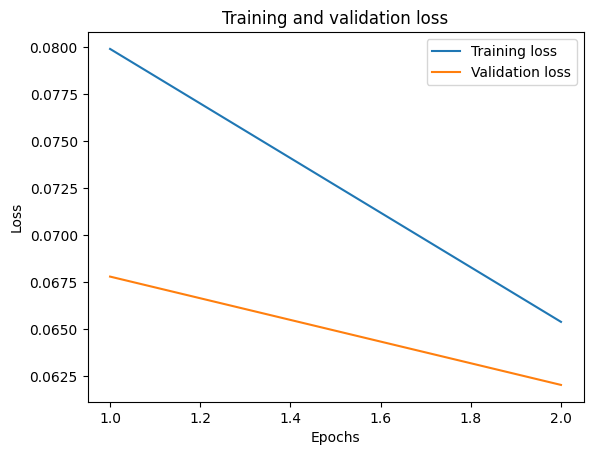

In [36]:

import matplotlib.pyplot as plt

# Plot the training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

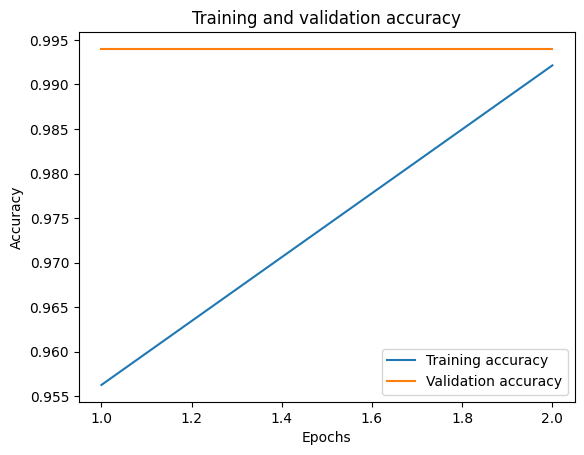

In [37]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [49]:
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('my_model.keras')

# Load the tokenizer (if you saved it separately)
# tokenizer = ...  # (load your tokenizer if needed)

# Assume tokenizer is already defined in your previous code

# Function to clean text (same as before)
'''def clean_text(text, remove_stopwords=True):
    # ... (your existing clean_text function) ...'''

# Function to predict toxicity (modified to use the loaded model)
def predict_toxicity(text, model, tokenizer):
    cleaned_text = clean_text(text)
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=MAX_SEQUENCE_LENGTH)  # Assuming MAX_SEQUENCE_LENGTH is defined
    prediction = model.predict(padded_sequence)[0]
    return prediction

# Get user input
user_input = input("Enter the text you want to analyze: ")

# Predict toxicity labels
prediction = predict_toxicity(user_input, model, tokenizer)

# Print the results with labels
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for i, label in enumerate(labels):
    print(f"{label}: {prediction[i]:.4f}")

Enter the text you want to analyze: fuck bitch you belong in the kitchen
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
toxic: 0.9977
severe_toxic: 0.6380
obscene: 0.9814
threat: 0.0262
insult: 0.8805
identity_hate: 0.1629


In [39]:
print(accuracy)
print(val_accuracy)
print(precision)

[0.9562734365463257, 0.9921351671218872]
[0.993983805179596, 0.993983805179596]


NameError: name 'precision' is not defined